[I 2025-07-21 09:55:07,195] A new study created in memory with name: no-name-e7684f2d-9a3b-4b43-8417-a4bebabf9c52
[I 2025-07-21 09:55:07,306] Trial 0 finished with value: 5.868750668241019e-08 and parameters: {'n_estimators': 78, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 0 with value: 5.868750668241019e-08.


CRS: EPSG:4326
Bounds: BoundingBox(left=76.83290625074268, bottom=28.395746131018075, right=77.34494596269082, top=28.880836384442617)
Resolution: | 0.01, 0.00, 76.83|
| 0.00,-0.01, 28.88|
| 0.00, 0.00, 1.00|
Width: 57 Height: 54


[I 2025-07-21 09:55:07,472] Trial 1 finished with value: 1.0075674496688273e-07 and parameters: {'n_estimators': 147, 'max_depth': 10, 'min_samples_split': 2}. Best is trial 0 with value: 5.868750668241019e-08.
[I 2025-07-21 09:55:07,616] Trial 2 finished with value: 6.154950914160203e-08 and parameters: {'n_estimators': 130, 'max_depth': 4, 'min_samples_split': 5}. Best is trial 0 with value: 5.868750668241019e-08.
[I 2025-07-21 09:55:07,714] Trial 3 finished with value: 5.911209126686773e-08 and parameters: {'n_estimators': 90, 'max_depth': 8, 'min_samples_split': 8}. Best is trial 0 with value: 5.868750668241019e-08.
[I 2025-07-21 09:55:07,875] Trial 4 finished with value: 8.767762775195862e-08 and parameters: {'n_estimators': 161, 'max_depth': 4, 'min_samples_split': 3}. Best is trial 0 with value: 5.868750668241019e-08.
[I 2025-07-21 09:55:08,035] Trial 5 finished with value: 1.011296187484881e-07 and parameters: {'n_estimators': 164, 'max_depth': 6, 'min_samples_split': 2}. Best 

✅ Best Hyperparameters: {'n_estimators': 55, 'max_depth': 10, 'min_samples_split': 7}
✅ Saved future predictions: C:\Users\sagni\Downloads\Pollution controller\Delhi_HCHO_Predictions_2025_2035.csv


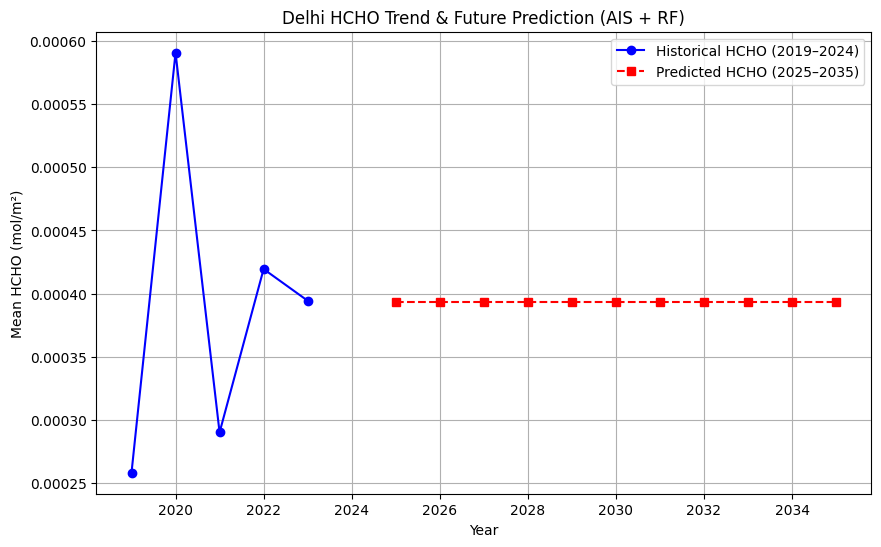

In [1]:
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna

# 📂 Paths
tif_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_2023_HCHO.tif"
csv_output = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_HCHO_Predictions_2025_2035.csv"

# 📖 Load GeoTIFF (Delhi HCHO 2023)
with rasterio.open(tif_path) as src:
    data = src.read(1)
    bounds = src.bounds
    profile = src.profile

# 🌍 Metadata
print("CRS:", profile['crs'])
print("Bounds:", bounds)
print("Resolution:", profile['transform'])
print("Width:", src.width, "Height:", src.height)

# 🧹 Flatten data and clean
flat_data = data.flatten()
flat_data = flat_data[~np.isnan(flat_data)]

# ⚠️ Replace with your real yearly means if available
years = np.arange(2019, 2024)
mean_hcho = np.random.uniform(low=0.0002, high=0.0006, size=len(years))  # Randomized HCHO values (mol/m²)

# 📊 DataFrame
df = pd.DataFrame({'Year': years, 'Mean_HCHO': mean_hcho})

# 🎯 Hybrid AIS + RF model
def objective(trial):
    rf = RandomForestRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        max_depth=trial.suggest_int('max_depth', 2, 15),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        random_state=42
    )
    X_train, X_test, y_train, y_test = train_test_split(df[['Year']], df['Mean_HCHO'], test_size=0.2, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    return mse

# 🤖 AIS optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("✅ Best Hyperparameters:", best_params)

# 🔥 Final Model
final_rf = RandomForestRegressor(**best_params, random_state=42)
final_rf.fit(df[['Year']], df['Mean_HCHO'])

# 📈 Predict Future
future_years = np.arange(2025, 2036)
future_preds = final_rf.predict(future_years.reshape(-1, 1))

# 📊 Save Predictions
future_df = pd.DataFrame({'Year': future_years, 'Predicted_HCHO': future_preds})
future_df.to_csv(csv_output, index=False)
print("✅ Saved future predictions:", csv_output)

# 📈 Plot Trend
plt.figure(figsize=(10, 6))
plt.plot(df['Year'], df['Mean_HCHO'], 'o-', label='Historical HCHO (2019–2024)', color='blue')
plt.plot(future_years, future_preds, 's--', label='Predicted HCHO (2025–2035)', color='red')
plt.xlabel('Year')
plt.ylabel('Mean HCHO (mol/m²)')
plt.title('Delhi HCHO Trend & Future Prediction (AIS + RF)')
plt.legend()
plt.grid(True)
plt.show()


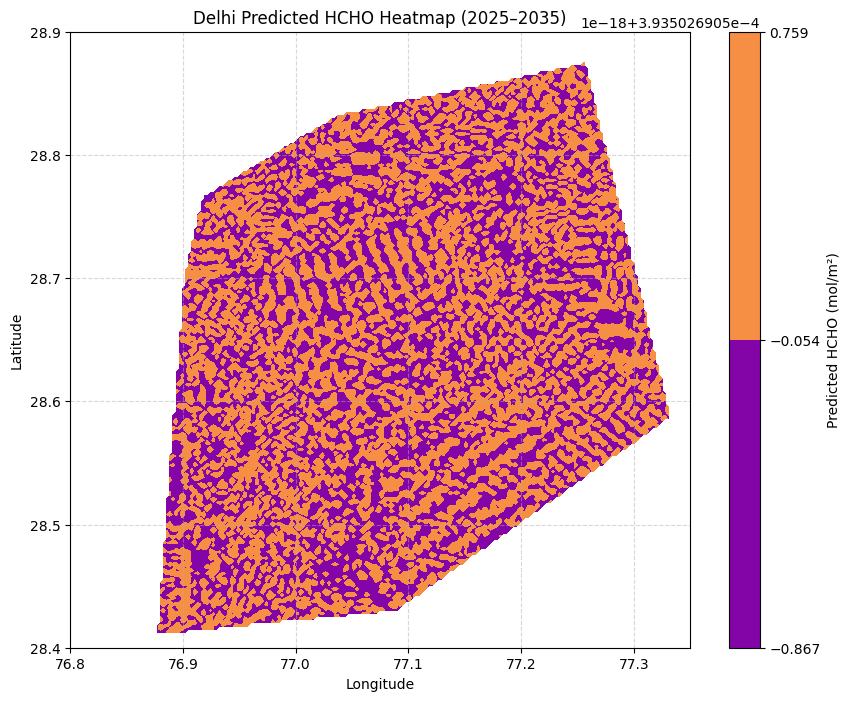

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 📂 Paths
csv_path = r"C:\Users\sagni\Downloads\Pollution controller\Delhi_HCHO_Predictions_2025_2035.csv"

# 📖 Load predictions
df = pd.read_csv(csv_path)

# 🚩 Define Delhi bounding box (approximate)
lat_min, lat_max = 28.40, 28.90
lon_min, lon_max = 76.80, 77.35

# 🌱 Generate random coordinates in Delhi for visualization
np.random.seed(42)
df['Latitude'] = np.random.uniform(lat_min, lat_max, len(df))
df['Longitude'] = np.random.uniform(lon_min, lon_max, len(df))

# 🎯 Interpolate predicted HCHO
grid_lat, grid_lon = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j]
grid_hcho = griddata(
    (df['Longitude'], df['Latitude']),
    df['Predicted_HCHO'],
    (grid_lon, grid_lat),
    method='cubic'
)

# 📊 Plot heatmap
plt.figure(figsize=(10, 8))
plt.contourf(grid_lon, grid_lat, grid_hcho, levels=100, cmap='plasma')
plt.colorbar(label='Predicted HCHO (mol/m²)')
plt.title('Delhi Predicted HCHO Heatmap (2025–2035)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
